In [1]:
from config_path import add_to_sys_path
add_to_sys_path()  # Call the function to add path

import numpy as np
from sympy.physics.wigner import wigner_3j,wigner_6j
import sympy as sy
from numpy import linalg as LA
from IPython.display import Latex
import matplotlib.pyplot as plt
%matplotlib inline

#The following three lines are only for asthetics and can be commented out if desired
import seaborn as sns
sns.set()
sns.set_palette('terrain')

from Energy_Levels import MoleculeLevels
np.set_printoptions(precision=5, suppress=True)

Added /Users/arianjadbabaie/Dropbox (Hutzler Lab)/HutzlerLabShared/Personal/ArianJadbabaie/Code/Molecular-Structure/Source Code to sys.path


This notebook computes the energy levels for $^{226}$RaF in E and B fields

First, we construct the Hamiltonian as a class carrying a symbolic function. Using this function, the Hamiltonian can be evaluated at different values of E and B. The symbolic function is assembled once, reducing the burden for large matrices.

The class initialization arguments are: isotope, state, N_range, M_values, I, S, round

isotope = string denoting isotope (ie '226')\
state = string denoting vibronic state (ie 'X010')\
N_range = tuple denoting (Nmin,Nmax)\
M_values = options are 'all', 'pos', 'none'. Default is 'all'. For accurate zero-field splittings, use 'none'.\
I = Array of nuclear spins, $[I_{Ra}, I_H]$. Default is $[0,1/2]$.\
S = Electronic spin. Default is 1/2.\
round = how many digits after decimal to round results 

In [2]:
X = MoleculeLevels.initialize_state('YbOH','174','X000',N_range=[0,1,2],M_values = 'all',I=[0,1/2],P_values=[1/2],S=1/2,round=6)

In [ ]:
for key in X.__dict__.keys(): print(key)

In [4]:
X.q_numbers

{'K': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'N': [0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'J': [0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  1.5,
  1.5,
  1.5,
  1.5,
  1.5,
  1.5,
  1.5,
  1.5],
 'F': [0.0,
  1.0,
  1.0,
  1.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0],
 'M': [0.0,
  -1.0,
  0.0,
  1.0,
  0.0,
  -1.0,
  0.0,
  1.0,
  -1.0,
  0.0,
  1.0,
  -2.0,
  -1.0,
  0.0,
  1.0,
  2.0]}

These are the attributes of the EnergyLevels class. They contain information about the state, constants, matrix elements as functions, as well as other information the instance was initialized with.

Library is a class that contains all possibly useful information and matrix elements, not just those for this particular state. This is useful for basis conversions, etc.

q_numbers is a dictionary containing the good quantum numbers of each basis vector. In this case (hunds case b), the basis vector is $|K;N,S,J,I,F,M\rangle$. Each dict item in q_numbers corresponds to one of the operators characterizing the basis and all its possible quantum numbers (ie eigenvalues). The ith basis vector is characterized by the ith index of each entry in q_numbers.
q_str is just the keys of q_numbers in a list.

In [9]:
i=0
print('Basis vector',i)
for q, q_value in X.q_numbers.items():
    print(q,'=',q_value[i])

Basis vector 0
K = 0
N = 0.0
J = 0.5
F = 0.0
M = 0.0


The Hamiltonian is stored in two forms: as a function, and as a symbolic object. The function form takes as an argument the values of two fields: an electric field $E_z$ and magnetic field $B_z$. It returns a numpy matrix of the Hamiltonian at those field values. This is the form you want to diagonalize. \
The symbolic form is a sympy object. It is not useful for diagonalization, but can be useful for visualizing the Hamiltonian.\
H_builder is the function used to construct the Hamiltonian.

In [12]:
print(X.H_function(0,0)[:,:])

[[  -72.225       0.          0.          0.          0.          0.
      0.          0.          0.          0.          0.          0.
      0.          0.          0.          0.     ]
 [    0.         24.075       0.          0.          0.          0.
      0.          0.          0.          0.          0.          0.
      0.          0.          0.          0.     ]
 [    0.          0.         24.075       0.          0.          0.
      0.          0.          0.          0.          0.          0.
      0.          0.          0.          0.     ]
 [    0.          0.          0.         24.075       0.          0.
      0.          0.          0.          0.          0.          0.
      0.          0.          0.          0.     ]
 [    0.          0.          0.          0.      11353.46488     0.
      0.          0.          0.          0.          0.          0.
      0.          0.          0.          0.     ]
 [    0.          0.          0.          0.          0

In [15]:
sy.N(X.H_symbolic[:6,:6],3)

Matrix([
[  -72.2,              0,   1.4*B_z,              0,         0,                   0],
[      0, 24.1 - 1.4*B_z,         0,              0,         0,          -0.656*E_z],
[1.4*B_z,              0,      24.1,              0, 0.656*E_z,                   0],
[      0,              0,         0, 1.4*B_z + 24.1,         0,                   0],
[      0,              0, 0.656*E_z,              0,   1.14e+4,                   0],
[      0,     -0.656*E_z,         0,              0,         0, 0.467*B_z + 1.13e+4]])

evals0 and evecs0 contain the eigenvalues and eigenvectors associated with the most recent diagonalization.
To diagonalize the matrix at a particular value of $E$ and $B$, use the eigensystem method. $E$ is the first argument, $B$ is the second.

The resulting eigenvectors and eigenvalues are written to the attributes evecs0 and evals0.

The order keyword arg will order the output eigenvalues from low to high, default is True. The method keyword arg controls the backend used for diagonalization, default is numpy LA.eig().

Note: If you have M_values not 'none', you will need a small B field (1e-8 or so) to remove the M degeneracy in the diagonalization. 

In [16]:
evals, evecs = X.eigensystem(0,1e-6,order=True,method='numpy')

Once the instance has eigenvalues and eigenvectors, you can use the write_state() method to visualize a given element in the eigenbasis. 

Note: write_state() looks at the current values of evecs0 and evals0

In [6]:
X.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5755.56,
 'Gamma_SR': 175.38,
 'bF': 96.3,
 'c': 19,
 'muE': 1.96834092,
 'D': 0.004197094412}

In [17]:
for i in range(4):
    X.write_state(i)

E = -72.225 MHz

 -1.0 |K=0,N=0.0,J=0.5,F=0.0,M=0.0> 

E = 24.074999 MHz

 -1.0 |K=0,N=0.0,J=0.5,F=1.0,M=-1.0> 

E = 24.075 MHz

 1.0 |K=0,N=0.0,J=0.5,F=1.0,M=0.0> 

E = 24.075001 MHz

 1.0 |K=0,N=0.0,J=0.5,F=1.0,M=1.0> 



For pretty fancy printing, you can use the gen_state_str method.\
If label_q = None, the default is to use all q numbers in the basis. If basis is None, the default is to use the existing basis. If basis is set to 'a' or 'decoupled', the quantum numbers for those bases will be used instead. \
Thresh sets the cutoff for coefficients to be included.

In [20]:
Latex(X.gen_state_str(0,label_q=['K','N','J','F','M'],basis=None,thresh=0.01,show_coeff=True,round=None))

<IPython.core.display.Latex object>

In [21]:
Latex(X.gen_state_str(0,label_q=['Sigma','K','P','J','F','M'],basis='aBJ',thresh=0.1,show_coeff=True,round=None))

<IPython.core.display.Latex object>

If M_values is not 'none', we can also generate Stark and Zeeman shift plots

In [7]:
Bz = np.linspace(1e-8,200,1000)
Ez = np.linspace(0.0,10000,1000)

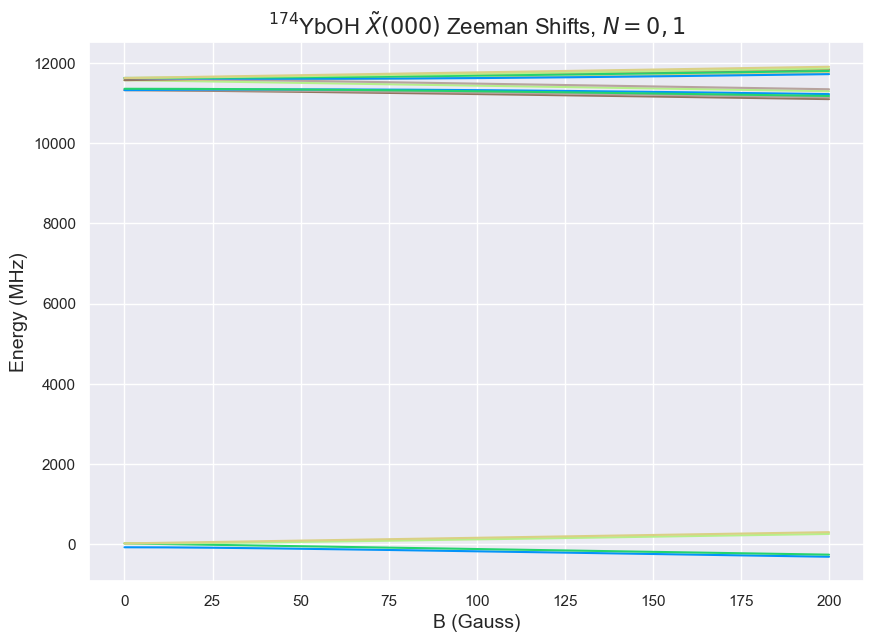

In [8]:
X.ZeemanMap(Bz,0,plot=True)

The field shifts are stored as attributes. This allows us to compute the derivative of the Zeeman shifts, which tells us the magnetization of the levels.

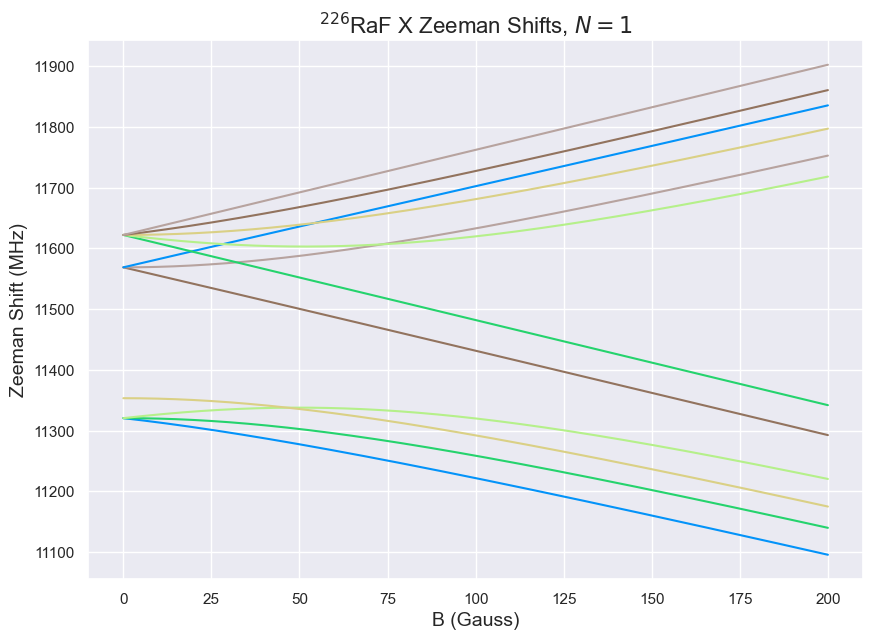

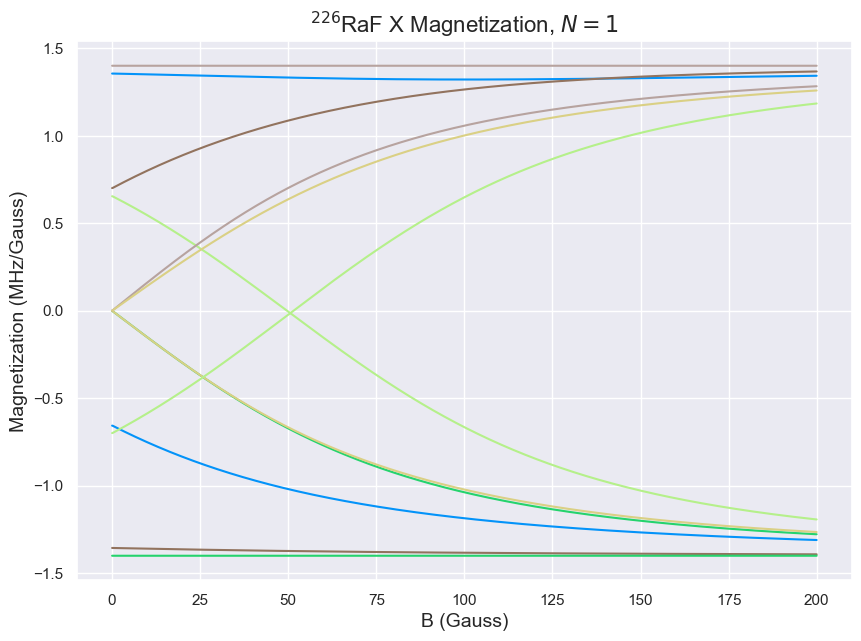

In [9]:
dB = Bz[1] - Bz[0]
idx = X.select_q({'N':1})
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X.evals_B.T[idx]):
    plt.plot(Bz,trace)
plt.xlabel('B (Gauss)',fontsize=14)
plt.ylabel('Zeeman Shift (MHz)',fontsize=14)
plt.title(r'$^{226}$RaF X Zeeman Shifts, $N=1$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X.evals_B.T[idx]):
    plt.plot(Bz,np.gradient(trace,dB))
plt.xlabel('B (Gauss)',fontsize=14)
plt.ylabel('Magnetization (MHz/Gauss)',fontsize=14)
plt.title(r'$^{226}$RaF X Magnetization, $N=1$',fontsize=16);

We can either plot directly with the StarkMap/ZeemanMap function, or we can use plot_evals_EB() to plot with additional options.

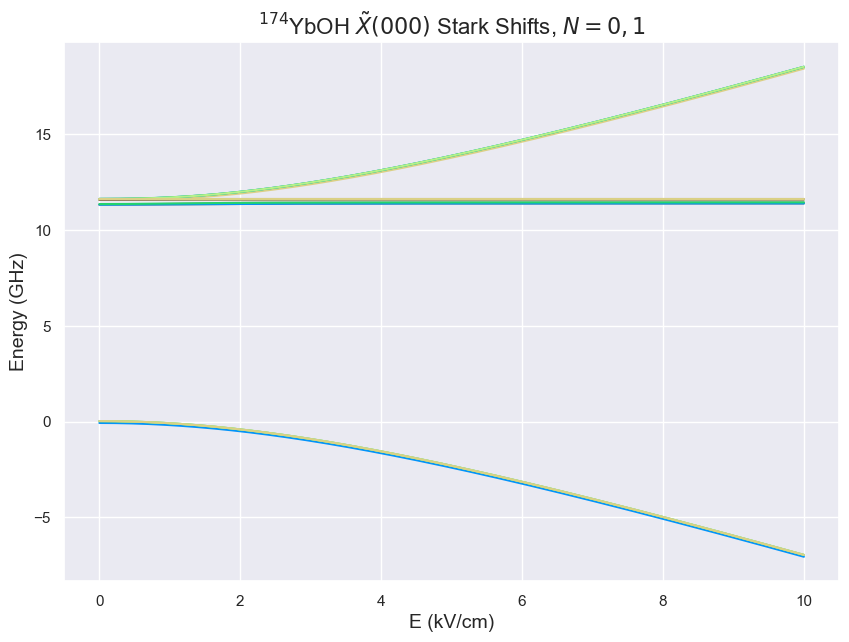

In [10]:
X.StarkMap(Ez,1e-5,plot=False)
X.plot_evals_EB('E',kV_kG=True,GHz=True)

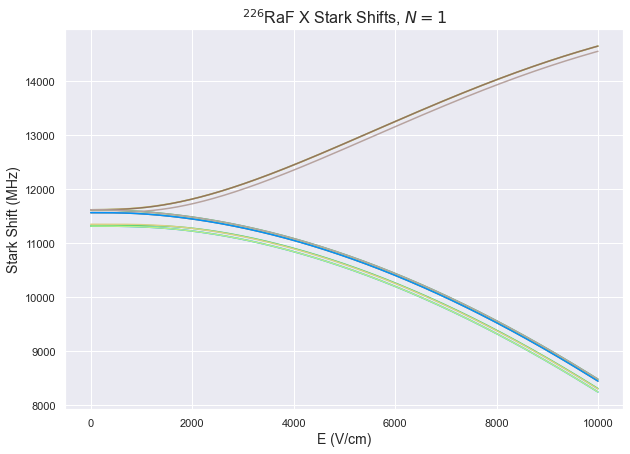

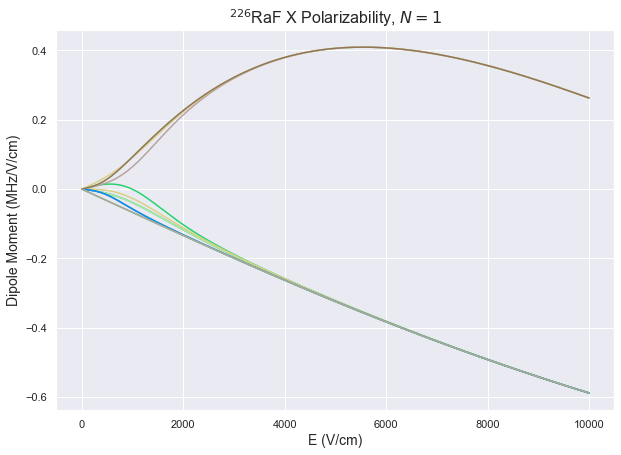

In [47]:
dE = Ez[1] - Ez[0]
idx = X.select_q({'N':1})
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X.evals_E.T[idx]):
    plt.plot(Ez,trace)
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Stark Shift (MHz)',fontsize=14)
plt.title(r'$^{226}$RaF X Stark Shifts, $N=1$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(X.evals_E.T[idx]):
    plt.plot(Ez,np.gradient(trace,dE))
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Dipole Moment (MHz/V/cm)',fontsize=14)
plt.title(r'$^{226}$RaF X Polarizability, $N=1$',fontsize=16);

We can display a plot of the energy levels at arbitray field. (The code does not handle parity labeling well, so I am leaving out L for zero field.)\
The first and second argument are the E and B field values. The third argument is the pattern forming quantum number that sets how often the levels are labeled.

In [106]:
help(X.display_levels)

Help on method display_levels in module Energy_Levels:

display_levels(Ez, Bz, pattern_q, idx=None, label=True, label_off=0.03, parity=False, pretty=True, thickness=1.5, label_q=None, width=0.75, ket_size=10, label_size=14, figsize=(10, 10), ylim=None, deltaE_label=3000, alt_label=False) method of Energy_Levels.MoleculeLevels instance



In [25]:
for E0 in X.evals0:
    print(E0)

-72.225
24.074999
24.075
24.075001
11320.614441
11320.614442
11320.614443
11353.464878
11568.918647
11568.918648
11568.918649
11622.234877
11622.234878
11622.234878
11622.234879
11622.23488


In [123]:
11568-11622

-54

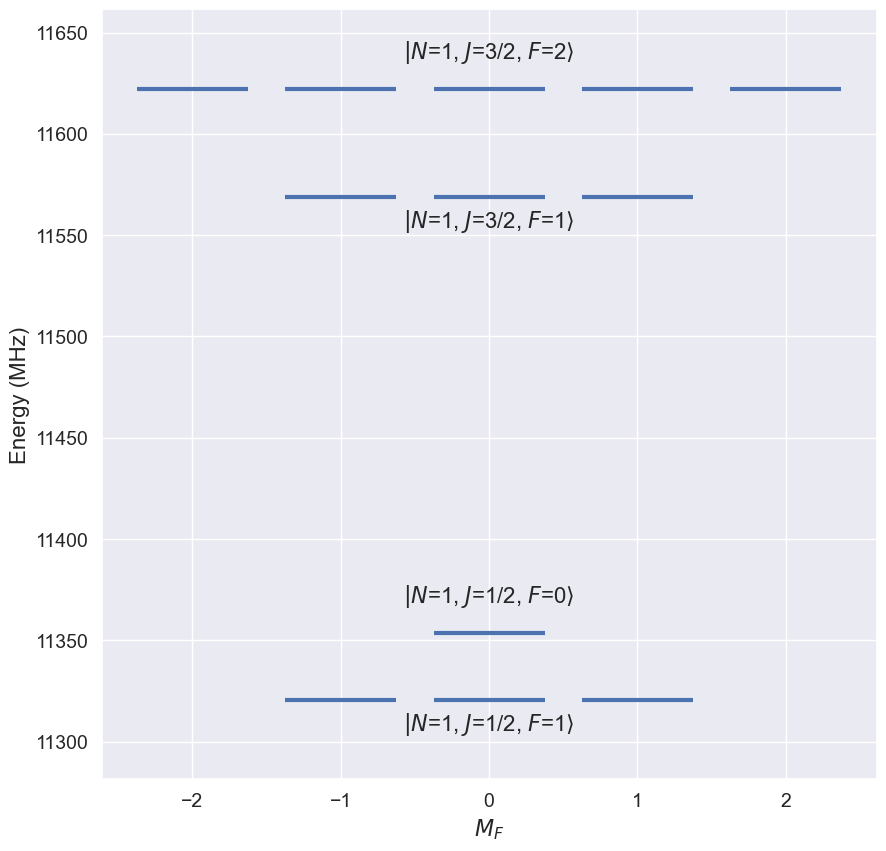

In [26]:
X.display_levels(0,1e-8,'F',label_q=[q for q in X.q_str if q!='K'],idx=idx,alt_label=True,thickness=3,label_size=16,ket_size=16,label_off=0.05);

Additionally we can look at g-factors and dipole moments at a given E, B field

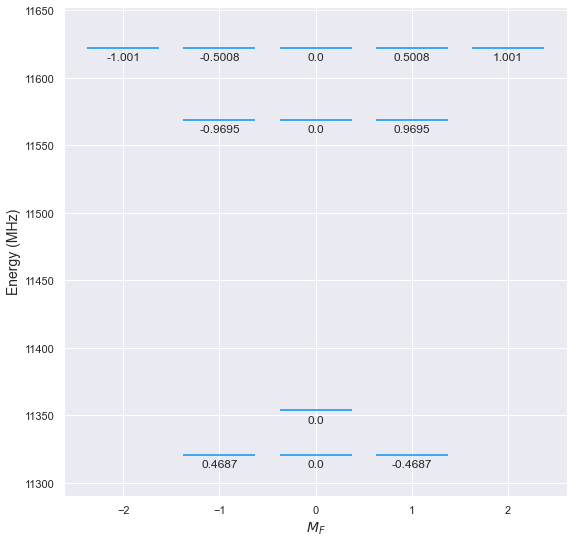

In [133]:
X.display_g_eff(0,1e-3,step=1e-3,round=4,idx=idx);

In [8]:
A = MoleculeLevels.initialize_state('YbOH','174','A000',N_range=[1,2],M_values = 'all',I=[0,1/2],P_values=[1/2],S=1/2,round=5)

h1/2: 499.99999999999994 0.49999999999999994
0 0
h1/2: -499.99999999999994 -0.49999999999999994
1 1
h1/2: -166.66666666666666 -0.16666666666666666
2 2
d param: 83.33333333333333
2 3
d param: 83.33333333333333
3 2
h1/2: 166.66666666666666 0.16666666666666666
3 3
d param: 117.8511301977579
3 8
h1/2: -166.66666666666666 -0.16666666666666666
4 4
d param: 83.33333333333333
4 5
d param: 83.33333333333333
5 4
h1/2: 166.66666666666666 0.16666666666666666
5 5
d param: 117.8511301977579
5 10
h1/2: -166.66666666666666 -0.16666666666666666
6 6
d param: 83.33333333333333
6 7
d param: 83.33333333333333
7 6
h1/2: 166.66666666666666 0.16666666666666666
7 7
d param: 117.8511301977579
7 12
d param: 117.8511301977579
8 3
h1/2: 166.66666666666666 0.16666666666666666
8 8
h1/2: -166.66666666666666 -0.16666666666666666
9 9
d param: 117.8511301977579
10 5
h1/2: 166.66666666666666 0.16666666666666666
10 10
h1/2: -166.66666666666666 -0.16666666666666666
11 11
d param: 117.8511301977579
12 7
h1/2: 166.6666666666

In [3]:
A.write_state(15)
A.write_state(13)

E = 11884.5313 MHz

 0.70702 |K=1,Σ=-0.5,P=0.5,J=0.5,F=1.0,M=-1.0> 

 0.7072 |K=-1,Σ=0.5,P=-0.5,J=0.5,F=1.0,M=-1.0> 

 1e-05 |K=1,Σ=-0.5,P=0.5,J=0.5,F=1.0,M=0.0> 

 1e-05 |K=-1,Σ=0.5,P=-0.5,J=0.5,F=1.0,M=0.0> 

 0.00116 |K=1,Σ=-0.5,P=0.5,J=1.5,F=1.0,M=-1.0> 

 -0.00143 |K=-1,Σ=0.5,P=-0.5,J=1.5,F=1.0,M=-1.0> 

E = 11884.5313 MHz

 -0.70702 |K=1,Σ=-0.5,P=0.5,J=0.5,F=1.0,M=1.0> 

 -0.7072 |K=-1,Σ=0.5,P=-0.5,J=0.5,F=1.0,M=1.0> 

 -0.00116 |K=1,Σ=-0.5,P=0.5,J=1.5,F=1.0,M=1.0> 

 0.00143 |K=-1,Σ=0.5,P=-0.5,J=1.5,F=1.0,M=1.0> 



In [36]:
A.H_symbolic[0:8,0:8]

Matrix([
[                          5726.47580290559,                           6151.38517323065,                                                            0,                                                            0, -0.000536522722699828*B_z - 0.07215572*E_z,                        -0.337776044552*B_z,                                                             0,                                                             0],
[                          6151.38517323065,                           5726.47580290559,                                                            0,                                                            0,                        -0.337776044552*B_z, -0.000536522722699828*B_z + 0.07215572*E_z,                                                             0,                                                             0],
[                                         0,                                          0, 0.000536522722699828*B_z + 0.07215572*E_z + 57

In [7]:
A.H_symbolic[0:6,0:6]

Matrix([
[                          6226.47580290559,                           5906.38517323065,                                                            0,                                                            0, -0.000536522722699828*B_z - 0.07215572*E_z,                        -0.337776044552*B_z],
[                          5906.38517323065,                           5226.47580290559,                                                            0,                                                            0,                        -0.337776044552*B_z, -0.000536522722699828*B_z + 0.07215572*E_z],
[                                         0,                                          0, 0.000536522722699828*B_z + 0.07215572*E_z + 5559.80913623892,                        0.337776044552*B_z + 6239.71850656398,                                          0,                                          0],
[                                         0,                                         

In [28]:
aparam = A.parameters
aparam

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5726.48,
 'ASO': 0.0,
 'h1/2': 9.5,
 'bF': 0,
 'c': 0,
 'd': 10,
 'p+2q': -12312.776042518,
 'q': 0,
 'D': 0.004197094412,
 'p2q_D': 0.005696056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 13284.427}

In [37]:
aparam['h1/2']=19/2
aparam['d']=10
A.update_params(aparam)

h1/2: 4.749999999999999 0.49999999999999994
0 0
h1/2: -4.749999999999999 -0.49999999999999994
1 1
h1/2: -1.5833333333333333 -0.16666666666666666
2 2
d param: 1.6666666666666665
2 3
d param: 1.6666666666666665
3 2
h1/2: 1.5833333333333333 0.16666666666666666
3 3
d param: 2.3570226039551576
3 8
h1/2: -1.5833333333333333 -0.16666666666666666
4 4
d param: 1.6666666666666665
4 5
d param: 1.6666666666666665
5 4
h1/2: 1.5833333333333333 0.16666666666666666
5 5
d param: 2.3570226039551576
5 10
h1/2: -1.5833333333333333 -0.16666666666666666
6 6
d param: 1.6666666666666665
6 7
d param: 1.6666666666666665
7 6
h1/2: 1.5833333333333333 0.16666666666666666
7 7
d param: 2.3570226039551576
7 12
d param: 2.3570226039551576
8 3
h1/2: 1.5833333333333333 0.16666666666666666
8 8
h1/2: -1.5833333333333333 -0.16666666666666666
9 9
d param: 2.3570226039551576
10 5
h1/2: 1.5833333333333333 0.16666666666666666
10 10
h1/2: -1.5833333333333333 -0.16666666666666666
11 11
d param: 2.3570226039551576
12 7
h1/2: 1.58

In [38]:
A.eigensystem(0,1e-5);

In [39]:
Bz = np.linspace(1e-8,100,10000)
Ez = np.linspace(0.0,10000,10000)

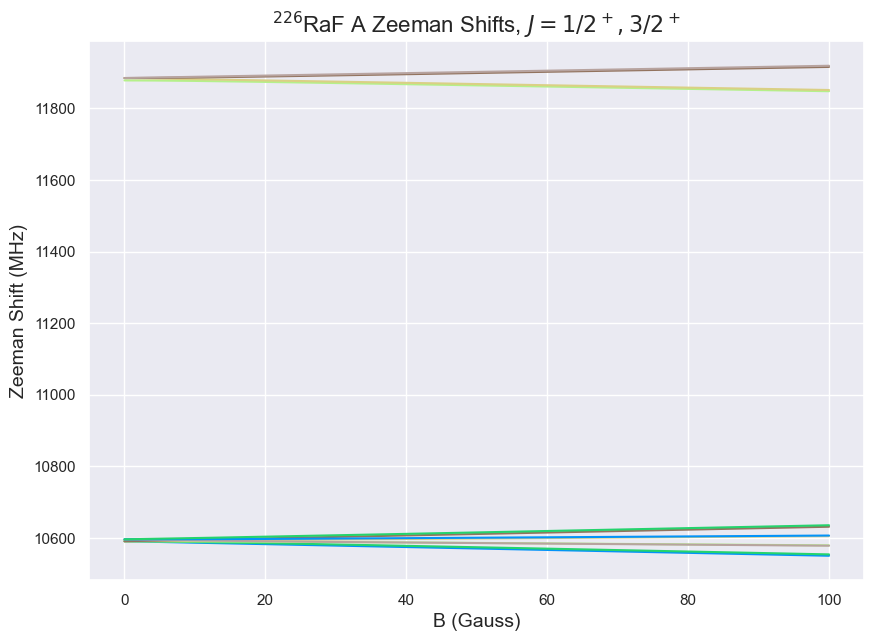

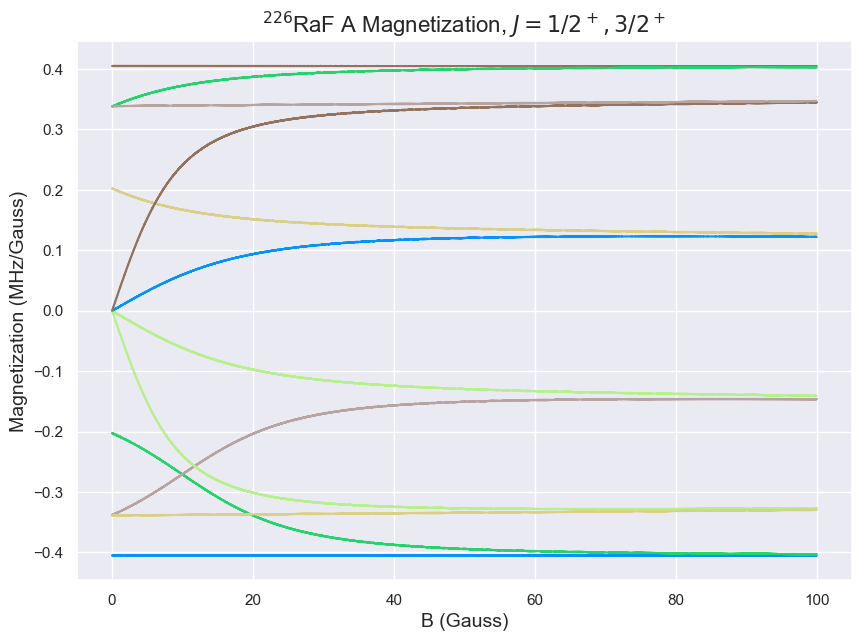

In [40]:
A.ZeemanMap(Bz,0,plot=False);
idx=A.select_q({'J':[1/2,3/2]},parity='+')
dB = Bz[1] - Bz[0]
plt.figure(figsize=(10,7))
for (i,trace) in enumerate(A.evals_B.T[idx]):
    plt.plot(Bz,trace-0*A.evals_B.T[idx][0][0])
plt.xlabel('B (Gauss)',fontsize=14)
plt.ylabel('Zeeman Shift (MHz)',fontsize=14)
plt.title(r'$^{226}$RaF A Zeeman Shifts, $J=1/2^+,3/2^+$',fontsize=16);

plt.figure(figsize=(10,7))
for (i,trace) in enumerate(A.evals_B.T[idx]):
    plt.plot(Bz,np.gradient(trace,dB))
plt.xlabel('B (Gauss)',fontsize=14)
plt.ylabel('Magnetization (MHz/Gauss)',fontsize=14)
plt.title(r'$^{226}$RaF A Magnetization, $J=1/2^+,3/2^+$',fontsize=16);

In [41]:
help(A.display_levels)

Help on method display_levels in module Energy_Levels:

display_levels(Ez, Bz, pattern_q, idx=None, label=True, label_off=0.03, parity=False, pretty=True, thickness=1.5, label_q=None, width=0.75, ket_size=10, label_size=14, figsize=(10, 10), ylim=None, deltaE_label=3000, alt_label=False) method of Energy_Levels.MoleculeLevels instance



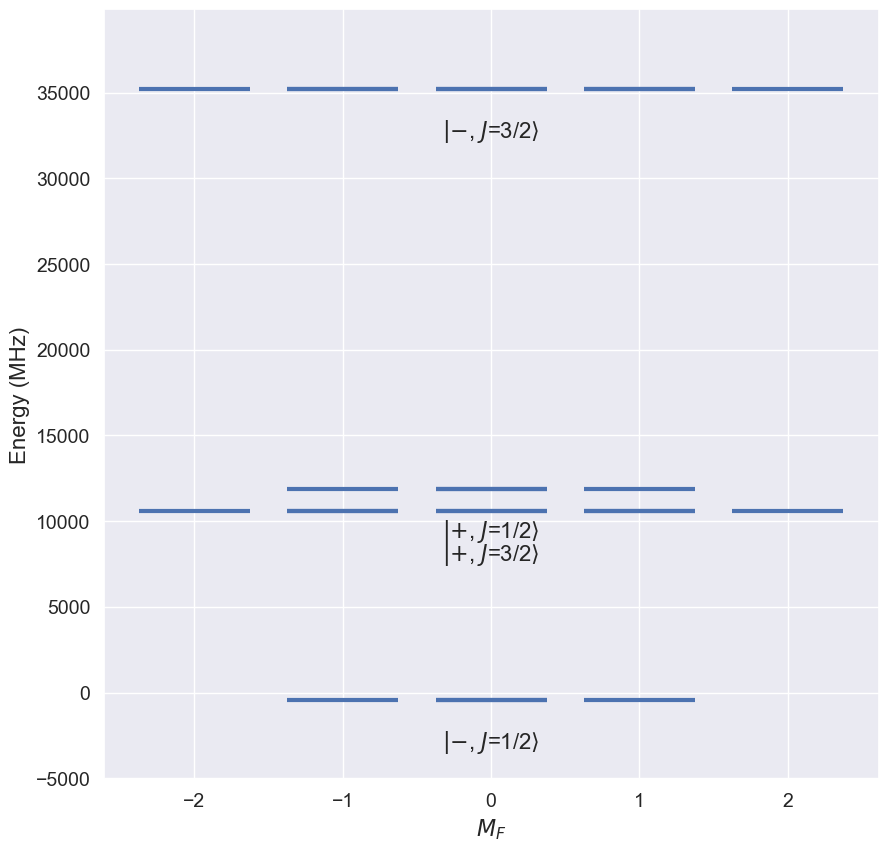

In [42]:
A.display_levels(0,1e-5,'J',label_q=[q for q in A.q_str if q!='K' and q!='Sigma' and q!='P'and q!='F'],parity=True,idx=A.select_q({'J':[1/2,3/2]}),alt_label=False,thickness=3,label_size=16,ket_size=16,label_off=0.08);

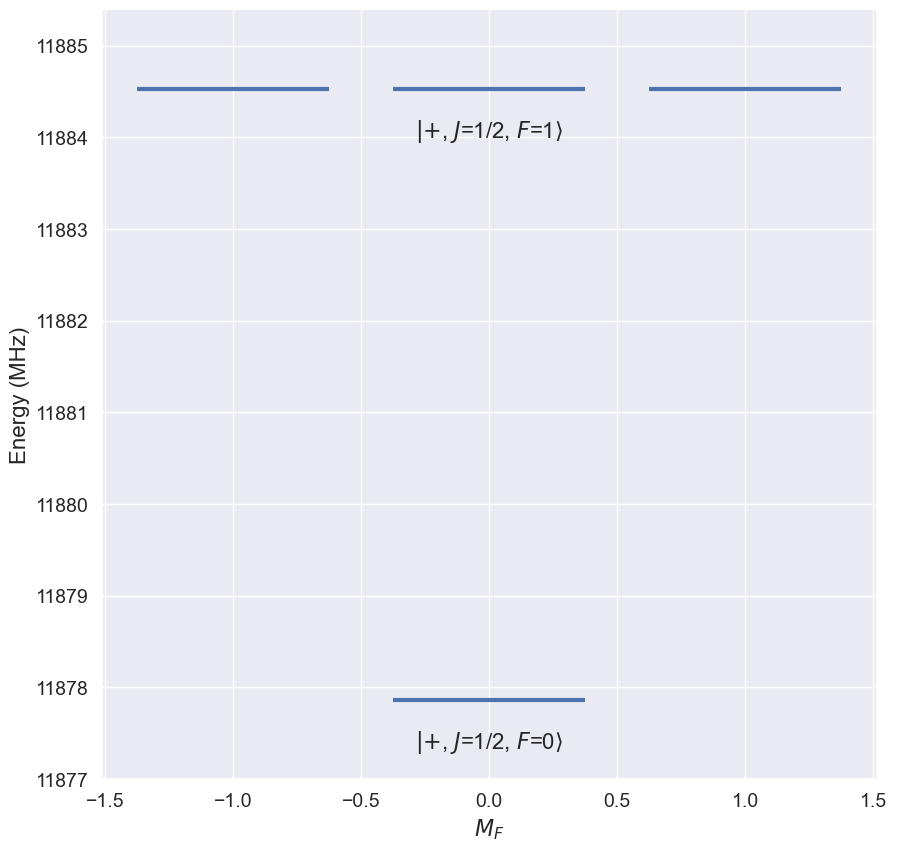

In [43]:
A.display_levels(0,1e-5,'F',label_q=[q for q in A.q_str if q!='K' and q!='Sigma' and q!='P'],parity=True,idx=A.select_q({'J':[1/2]},parity='+'),alt_label=False,thickness=3,label_size=16,ket_size=16,label_off=0.08);
plt.ticklabel_format(useOffset=False)

In [49]:
A.write_state(14)

E = 11884.5313 MHz

 0.70702 |K=1,Σ=-0.5,P=0.5,J=0.5,F=1.0,M=0.0> 

 0.7072 |K=-1,Σ=0.5,P=-0.5,J=0.5,F=1.0,M=0.0> 

 0.00116 |K=1,Σ=-0.5,P=0.5,J=1.5,F=1.0,M=0.0> 

 -0.00143 |K=-1,Σ=0.5,P=-0.5,J=1.5,F=1.0,M=0.0> 



In [53]:
0.00143**2

2.0449e-06

In [23]:
A.evals0

array([ -429.91834,  -429.91834,  -429.91833,  -429.91749, 10593.09515,
       10593.09515, 10593.09516, 10593.09516, 10593.09516, 10593.1072 ,
       10593.1072 , 10593.1072 , 11882.85807, 11882.85807, 11882.85807,
       11882.8691 , 33068.89281, 33068.89281, 33068.89281, 33068.89281,
       33068.89281, 33068.89282, 33068.89282, 33068.89703, 33068.89703,
       33068.89703, 33068.89703, 33068.89704, 35218.6035 , 35218.60351,
       35218.60351, 35218.60351, 35218.60351, 35218.61036, 35218.61037,
       35218.61037, 70007.06725, 70007.06726, 70007.06726, 70007.06726,
       70007.06726, 70007.06726, 70007.06726, 70007.07007, 70007.07007,
       70007.07007, 70007.07007, 70007.07007])

In [31]:
A.evals0

array([ -430.80594,  -430.80593,  -430.80593,  -430.72148, 10592.65622,
       10592.65623, 10592.65623, 10592.65623, 10592.65623, 10593.86067,
       10593.86067, 10593.86068, 11882.57042, 11882.57043, 11882.57043,
       11883.67309, 33068.88734, 33068.88734, 33068.88734, 33068.88734,
       33068.88735, 33068.88735, 33068.88735, 33069.30914, 33069.30915,
       33069.30915, 33069.30915, 33069.30915, 35218.3464 , 35218.3464 ,
       35218.3464 , 35218.34641, 35218.34641, 35219.03213, 35219.03213,
       35219.03213, 70007.07272, 70007.07272, 70007.07273, 70007.07273,
       70007.07273, 70007.07273, 70007.07273, 70007.35398, 70007.35398,
       70007.35398, 70007.35398, 70007.35399])

In [10]:
11023-12312

-1289

In [22]:
A.update_params({'ASO':0,'p+2q':-0.41071*29979.2458})

In [21]:
A.display_levels(0,1e-5,'J',label_q=[q for q in A.q_str if q!='K' and q!='Sigma' and q!='P'and q!='F'],parity=True,idx=A.select_q({'J':[1/2,3/2]}),alt_label=True,thickness=3,label_size=16,ket_size=16,label_off=0.05);

NameError: name 'A' is not defined

In [24]:
A.parameters

{'mu_B': 1.399624494,
 'g_S': 2.0023,
 'g_L': 1,
 '2_e0c': 75346062800.0,
 'mu_N': 0.000762259323,
 'Be': 5726.48,
 'ASO': 0,
 'a': 0.01,
 'bF': 0.06985,
 'c': 0.1799,
 'p+2q': -12312.776042518,
 'q': 0,
 'D': 0.0032170944120000003,
 'p2q_D': 0.004366056702,
 'g_lp': -0.724,
 'muE': 0.21646716,
 'Origin': 23769228.73504}

We can also look at PT violating shifts. Here, we consider the EDM shifts as a function of E field.

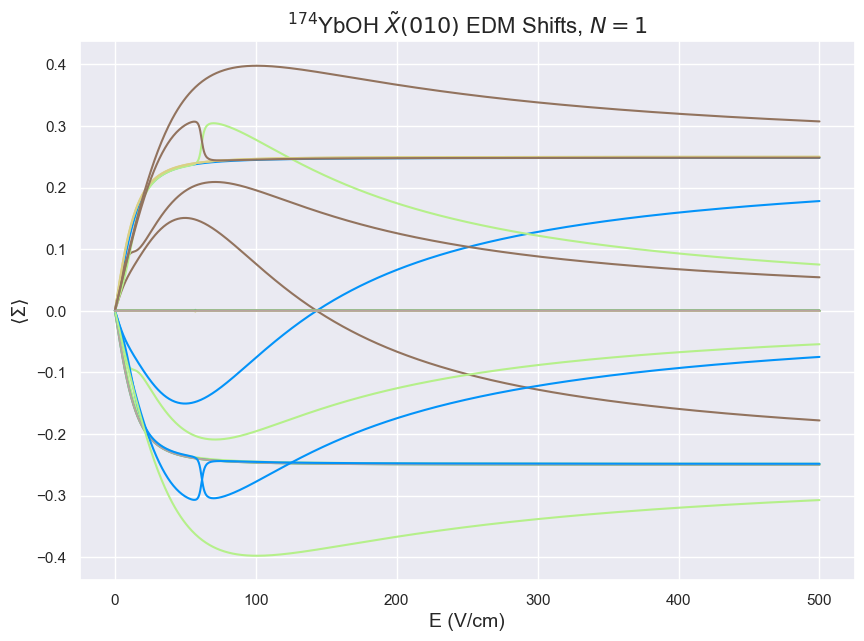

In [51]:
X010_174.PTV_Map('EDM',E_or_B='E',plot=True)

The values are stored in the attrbiute PTV_E or PTV_B, depending on what x-axis was used. To obtain the PTV shift for a single level as a function of field, look at the transpose of PTV_E.

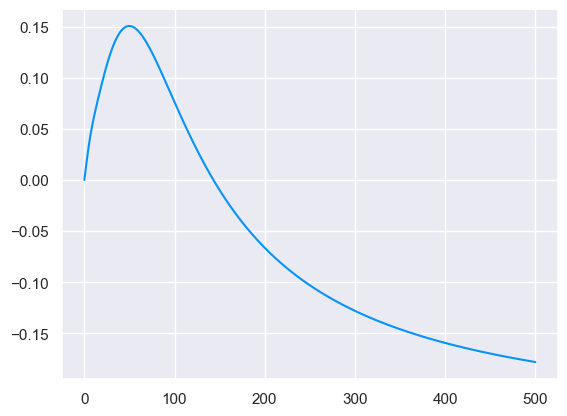

In [52]:
plt.plot(Ez,X010_174.PTV_E.T[4])

You can also display the PTV shifts for all levels in a given field configuration. Once again the first argument is E and the second is B

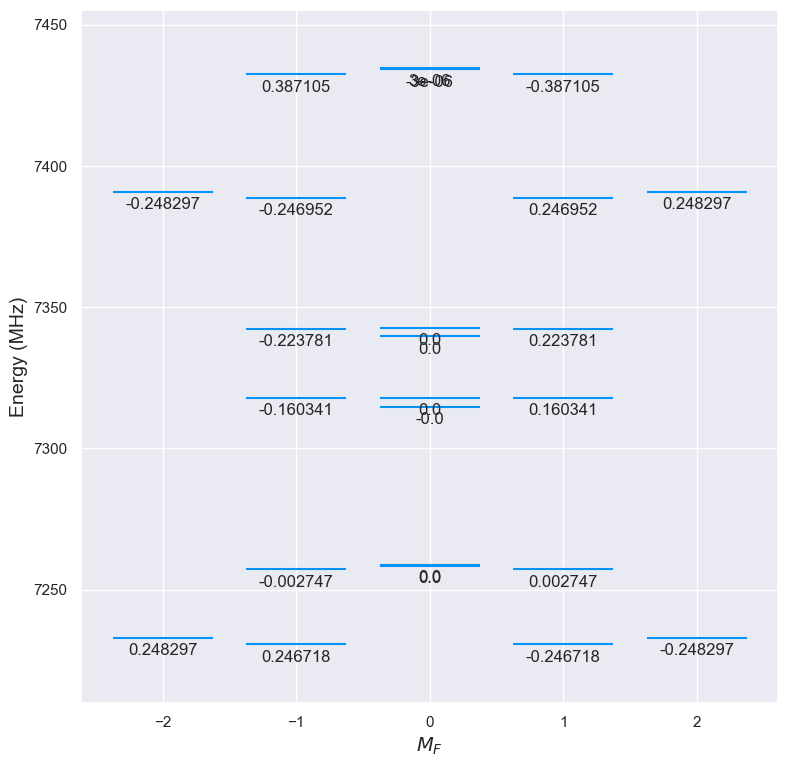

In [65]:
X010_174.display_PTV(145,1e-6,'EDM')

You can also look at g_factors as a function of E or B field. Note these functions require StarkMap and ZeemanMap to be run previously. If step is too small, the data will be noisy.

In [66]:
X010_174.g_eff_Map('E',step=1e-3);

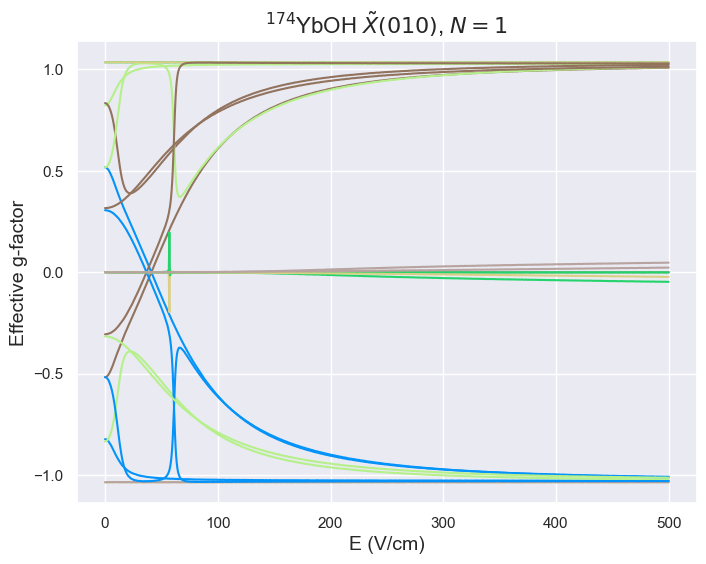

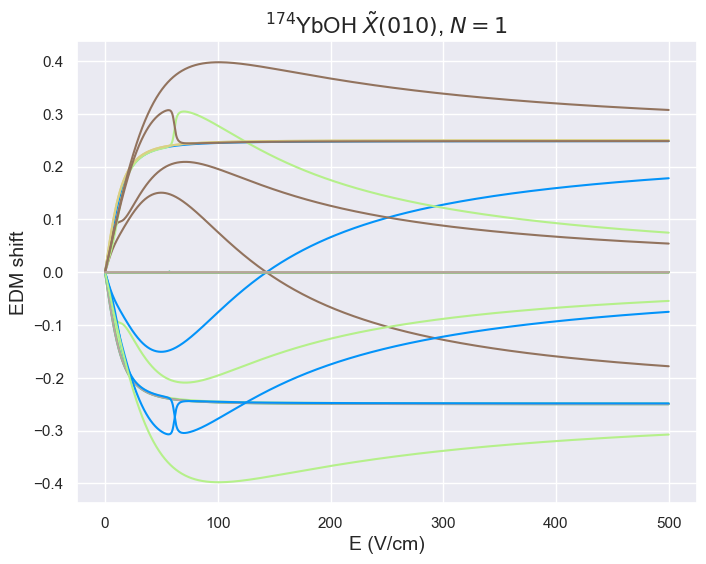

In [67]:
j = range(len(X010_174.evals0))
plt.figure(figsize=(8,6))
for i in j:#range(len(X010_174.g_eff_E.T)):
    plt.plot(Ez,X010_174.g_eff_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('Effective g-factor',fontsize=14)
plt.title(r'$^{174}$YbOH $\tilde{X}(010)$, $N=1$',fontsize=16);
plt.figure(figsize=(8,6))
for i in j:#range(len(X010_174.PTV_E.T)):
    plt.plot(Ez,X010_174.PTV_E.T[i])
plt.xlabel('E (V/cm)',fontsize=14)
plt.ylabel('EDM shift',fontsize=14)
plt.title(r'$^{174}$YbOH $\tilde{X}(010)$, $N=1$',fontsize=16);